C:\ProgramData\Miniconda3\lib\site-packages\torchvision\datasets\mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\ProgramData\Miniconda3\lib\site-packages\torchvision\datasets\mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\ProgramData\Miniconda3\lib\site-packages\torchvision\datasets\mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\ProgramData\Miniconda3\lib\site-packages\torchvision\datasets\mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])
MLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 2.3177 | test accuracy: 0.27


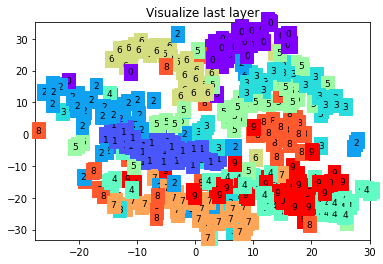

Epoch:  1 | train loss: 0.0822 | test accuracy: 0.89


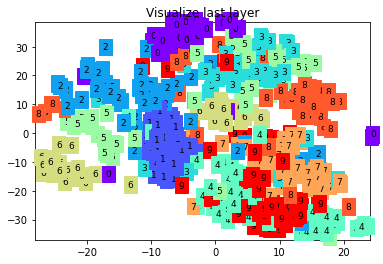

Epoch:  2 | train loss: 0.3609 | test accuracy: 0.89


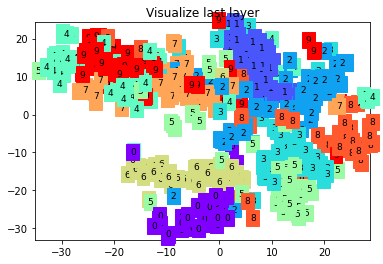

Epoch:  3 | train loss: 0.1101 | test accuracy: 0.90


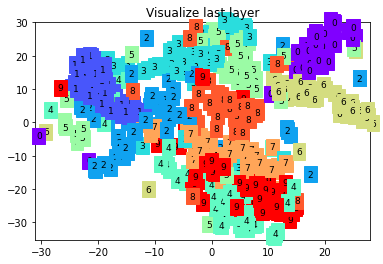

Epoch:  4 | train loss: 0.4918 | test accuracy: 0.89


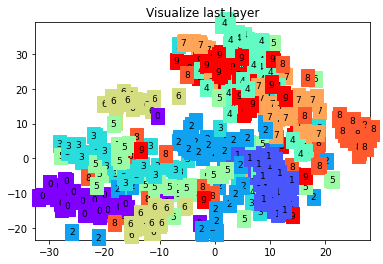

Epoch:  5 | train loss: 0.2349 | test accuracy: 0.90


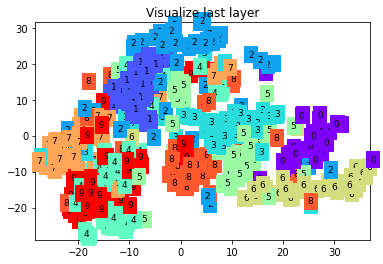

Epoch:  6 | train loss: 0.1040 | test accuracy: 0.89


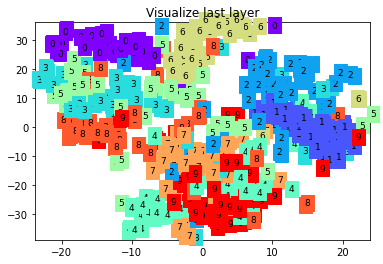

Epoch:  7 | train loss: 0.2148 | test accuracy: 0.90


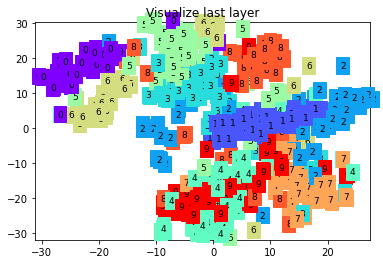

Epoch:  8 | train loss: 0.3922 | test accuracy: 0.90


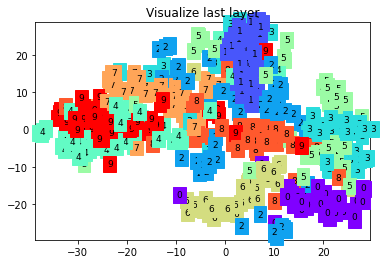

Epoch:  9 | train loss: 0.1622 | test accuracy: 0.90


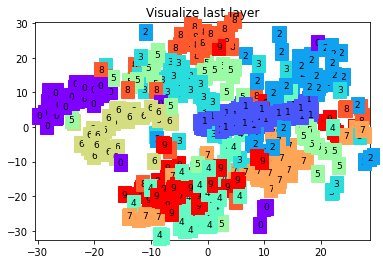

[7 2 1 0 4 1 4 9 6 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [1]:

# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False


# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
# plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
# plt.title('%i' % train_data.train_labels[0])
# plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(28*28,28*28),
            nn.Linear(28*28,10)
        )

    def forward(self, x):
        output = self.mlp(x)
        return output, x    # return x for visualization


mlp = MLP()
print(mlp)  # net architecture

optimizer = torch.optim.Adam(mlp.parameters(), lr=LR)   # optimize all logistic parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        # print(b_x.size())
        b_x = b_x.view(-1, 28*28)
        # print(b_x.size())

        output = mlp(b_x)[0]               # logistic output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 60000 == 0:

            test_output, last_layer = mlp(test_x.view(-1,28*28))
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

# print 10 predictions from test data
test_output, _ = mlp(test_x[:10].view(-1,28*28))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')